In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# 1. Load Data
print("Loading data")
import requests
import io

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data'
# Adding a header helps avoid 403 Forbidden errors. Bypass SSL verification due to certificate issues with the UCI server.
s = requests.get(url, verify=False).content
column_names = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']
df = pd.read_csv(io.StringIO(s.decode('utf-8')), names=column_names)

print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nValue counts for 'Sex' column:")
print(df['Sex'].value_counts())


Loading data

First 5 rows of the dataset:
  Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell_weight  Rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7  

Value counts for 'Sex' column:
Sex
M    1528
I    1342
F    1307
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'archive.ics.uci.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [ ]:
# 2. Feature Engineering

print("features maker")
df = pd.get_dummies(df, columns=['Sex'], prefix='Sex')

df['Volume'] = df['Length'] * df['Diameter'] * df['Height']
df['Density'] = df['Whole_weight'] / (df['Volume'] + 1e-5)

X = df.drop('Rings', axis=1)
y = df['Rings']

# Calculate Age (Biological Target)
# Adding 1.5 to Rings to get Age in years

df['Age'] = df['Rings'] + 1.5
print("\nValue counts for 'Age' column:")
print(df['Age'].value_counts())

print(df.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTotal columns: {len(df.columns)}")
print(f"Columns used: {list(X.columns)}")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

features maker

Value counts for 'Age' column:
Age
10.5    689
11.5    634
9.5     568
12.5    487
8.5     391
13.5    267
7.5     259
14.5    203
15.5    126
6.5     115
16.5    103
17.5     67
18.5     58
5.5      57
19.5     42
20.5     32
21.5     26
4.5      15
22.5     14
24.5      9
23.5      6
25.5      2
28.5      2
2.5       1
30.5      1
27.5      1
3.5       1
26.5      1
Name: count, dtype: int64
   Length  Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  \
0   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell_weight  Rings  Sex_F  Sex_I  Sex_M    Volume    Density   Age  
0         0.150     15  False  False   True  0.0157

In [ ]:
from sklearn.compose import TransformedTargetRegressor

# 3. Build and Train Polynomial Pipeline
print("\nTraining Polynomial Model")

# Using Degree 3 to capture complex growth curvatures
inner_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('regressor', Ridge(alpha=1.0)) # lower alpha for better fit
])

# Log transform
poly_pipeline = TransformedTargetRegressor(
    regressor=inner_pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

poly_pipeline.fit(X_train, y_train)


Training Polynomial Model


TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('scaler',
                                                      StandardScaler()),
                                                     ('poly_features',
                                                      PolynomialFeatures(include_bias=False)),
                                                     ('regressor', Ridge())]))

In [ ]:
# Evaluation Metrics

y_pred = poly_pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

y_pred_rounded = np.round(y_pred)
tolerance_acc = np.mean(np.abs(y_pred_rounded - y_test) <= 1) * 100
tolerance_acc2 = np.mean(np.abs(y_pred_rounded - y_test) <= 2) * 100

print("\n" + "="*50)
print(" POLYNOMIAL REG EVALUATION METRICS ")
print("="*50)
print(f"Mean Absolute Error (MAE): {mae:.4f} rings")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f} rings")
print(f"R^2 Score: {r2:.4f}")
print(f"Tolerance Accuracy (+/- 1 Ring): {tolerance_acc:.2f}%")
print(f"Tolerance Accuracy (+/- 2 Ring): {tolerance_acc2:.2f}%")


 POLYNOMIAL REG EVALUATION METRICS 
Mean Absolute Error (MAE): 1.4832 rings
Root Mean Squared Error (RMSE): 2.1315 rings
R^2 Score: 0.5803
Tolerance Accuracy (+/- 1 Ring): 65.07%
Tolerance Accuracy (+/- 2 Ring): 82.78%



Generating Evaluation Charts


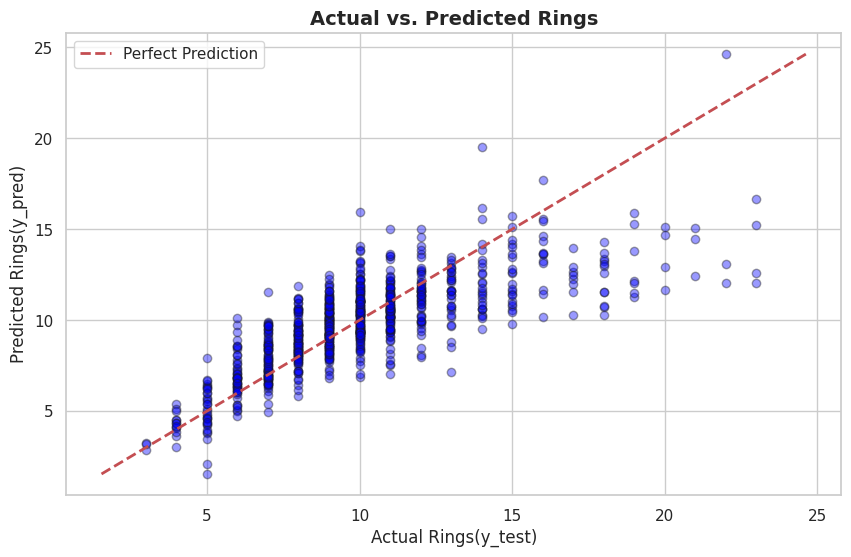

In [ ]:
# 5. GENERATE EVALUATION GRAPHS
print("\nGenerating Evaluation Charts")
sns.set_theme(style="whitegrid")

# --- CHART 1: Actual vs Predicted Rings ---
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.4, color='blue', edgecolor='k')
min_val, max_val = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
plt.title('Actual vs. Predicted Rings', fontsize=14, fontweight='bold')
plt.xlabel('Actual Rings(y_test)', fontsize=12)
plt.ylabel('Predicted Rings(y_pred)', fontsize=12)
plt.legend()
plt.savefig('1_actual_vs_predicted.png')
plt.show()

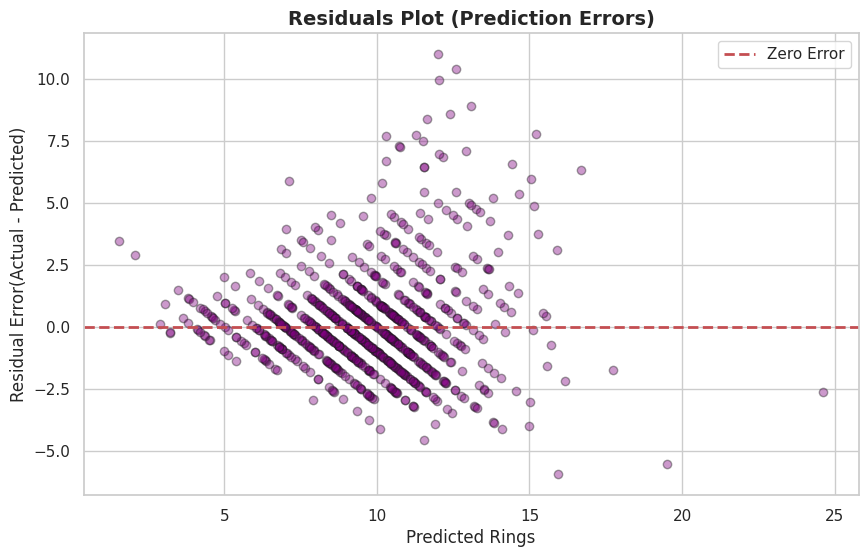

In [ ]:
# --- CHART 2: Residual Plot ---
# Residuals = Actual - Predicted
plt.figure(figsize=(10, 6))
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.4, color='purple', edgecolor='k')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
plt.title('Residuals Plot (Prediction Errors)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Rings', fontsize=12)
plt.ylabel('Residual Error(Actual - Predicted)', fontsize=12)
plt.legend()
plt.savefig('2_residuals_plot.png')
plt.show()